# Introduction
This notebook will show how we can pre-process the input dataset of the Titanic's problem so we can extract useful features. With good features, then we'll try to forecast the survival on the Titanic with a SVM

# The dataset
We know that the Titanic collided an iceberg causing the death of 1502 out of 2224 passengers because of the lack of lifeboat. But when looking at the profile of the survivor we can see that some groups were more likely to survive like children and women. So our goal is to find a model to predict who is more likely to survive depending on its profile.
 
So let's have an overview of the training data. First let's do all the necessary includes.

In [1]:
import re
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time
import random
from subprocess import check_call
from IPython.display import Image as PImage

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss, roc_curve, auc
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.cross_validation import train_test_split
from sklearn import tree
%matplotlib inline

# usefull function for later use
def surviveByGroup(data, group):
	return data[['Survived',group]].groupby([group], as_index=False).agg(['mean', 'count']) .sort_values([('Survived','mean')], ascending=False)


Then we can load the data and see the first rows:

In [2]:
data_train = pd.read_csv('../input/train.csv')
data_test  = pd.read_csv('../input/test.csv')
# preview the data
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


At first glance, we can see that the PassengerId is just a technical field for this given problem, so we can forget it. 

### The name
The Name of passengers seems not to give useful information but we can extract the title and group them. Also, we could extract the family name to have an idea of all the family aboard, but we might encounter the same surname for unrelated groups of people.

In [3]:
def processName(name):
	title_dict = {'Mrs':'Mrs', 'Mr':'Mr', 'Miss':'Miss',
				  'Ms':'RareFem','Mlle':'RareFem','Countess':'RareFem','Lady':'RareFem', 'Dona' : 'RareFem',
				  'Master':'Master',
				  'Dr':'Dr',
				  'Major':'RareA', 'Col':'RareA', 'Don':'RareA', 'Sir':'RareA',
				  'Rev':'RareZ', 'Jonkheer':'RareZ',  'Capt':'RareZ' 
				}
	for title in title_dict.keys():
		if name.find(title) != -1:
			return title_dict[title]
	return 'None'

data_train['Title'] = data_train['Name'].map(processName)
data_train['Title'] = data_train['Title'].fillna('')
surviveByGroup(data_train, 'Title')

Survived      
             mean count
Title                  
None     1.000000     1
RareFem  0.800000     5
Mrs      0.785714   126
Miss     0.696629   178
Master   0.575000    40
Dr       0.545455    11
RareA    0.312500    16
Mr       0.158103   506
RareZ    0.000000     8

### Sex
So we can see that the title can give valuable information. However, it's strongly correlated to the Sex field.

In [4]:
surviveByGroup(data_train, 'Sex')

Survived      
            mean count
Sex                   
female  0.742038   314
male    0.188908   577

### Age


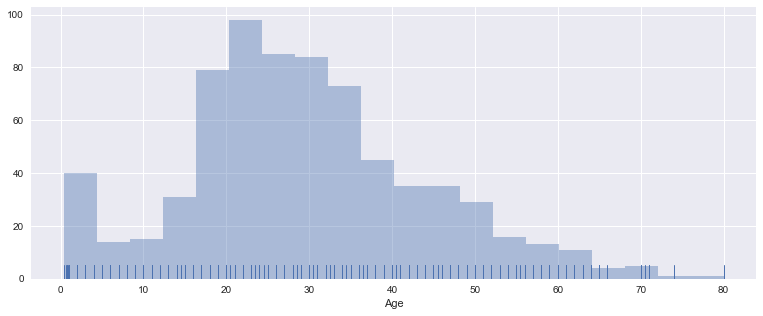

In [5]:
fig, ax = plt.subplots(figsize=(13,5))

data_age = data_train['Age'].dropna()
sns.distplot(data_age, hist=True, rug=True, kde=False,ax=ax)
# we need to manage empty values
data_train['Age'].fillna(data_train['Age'].median(),inplace=True)

# Family size
Then we can sum SibSp and Parch to get the number of family member with each passenger. From this data we can deduce that small families (of less than 5 persons) are better at survival.

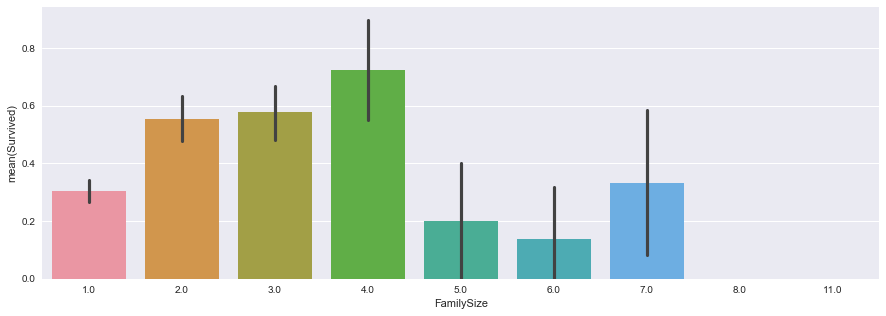

In [6]:
data_train['FamilySize'] = data_train['SibSp'] + data_train['Parch'] + 1.0
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=data_train['FamilySize'], y=data_train['Survived'], ax=ax)

### Fare
Here we can see that small families are better for survivale than a person alone or a large family. But then we want to know how much the ticket cost for everyone. We can compute the fare per person also, based on the fact that multiple persons aboard shared the same tickets, but we will assume that de family size feature is accurate.

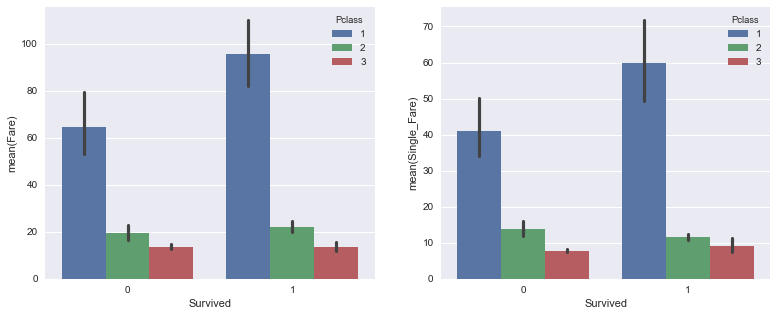

In [7]:
fare_data = data_train[['Survived','Fare','FamilySize','Pclass']].dropna()

# compute the fare per person
fare_data['Single_Fare'] = fare_data['Fare']/fare_data['FamilySize']
# plot data
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(13,5))
sns.barplot(y="Fare", x="Survived", hue="Pclass", data=fare_data, ax=axis1)
sns.barplot(y="Single_Fare", x="Survived", hue="Pclass", data=fare_data, ax=axis2)
# replace missing values by the median as first approximation for the next computations
data_train['Fare'].fillna(data_train['Fare'].median(),inplace = True)

As we can see, the fare per person doesn't seem to give much more information : we can keep the global fare as feature, but keeping in mind that it is correlated to the family size and the class (see the chart below). So, the fare can be used as it or we need to investigate more if we want to get a more relevant feature from it.

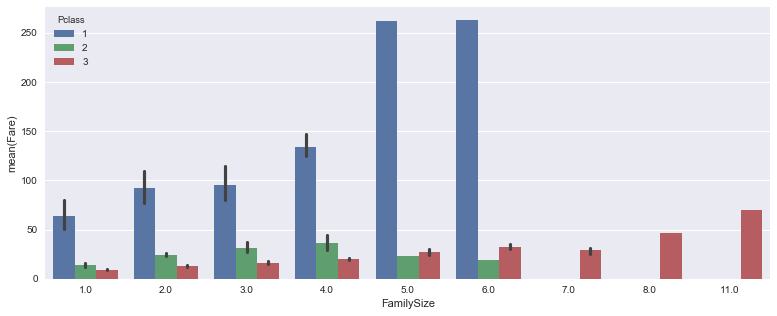

In [8]:
fig, ax = plt.subplots(1,figsize=(13,5))
sns.barplot(y="Fare", x="FamilySize", hue="Pclass", data=fare_data,ax=ax)

### Passenger class
Then we can study the class of the passengers, and we can see that the 1st class as a higher survival rate than the 3rd class:

Survived      
            mean count
Pclass                
1       0.629630   216
2       0.472826   184
3       0.242363   491

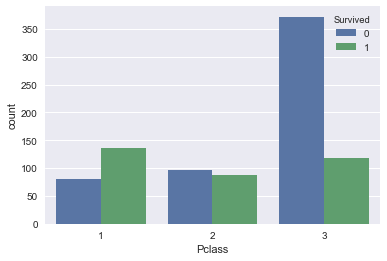

In [9]:
sns.countplot(hue="Survived", x='Pclass', data=data_train)
surviveByGroup(data_train, 'Pclass')

# Embark location

Also, by looking at the Embarked column, we can see that the passenger who embarked at Cherbourg where more likely to survive than those who embarked at Queenstown or Southampton.

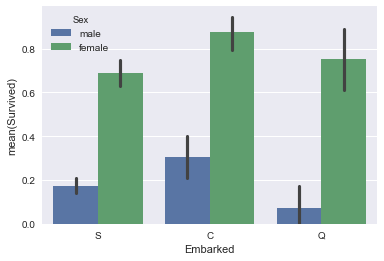

In [10]:
sns.barplot(y="Survived", x='Embarked', hue='Sex', data=data_train)

### Cabins

Now we'll study the cabins. First we can see that a lot of passenger doesn't have any cabin assigned. For the other, the cabin information is a letter representing the deck followed by a number: the room number. At least we can see if the deck has an impact on survival:

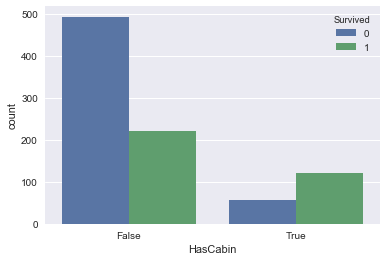

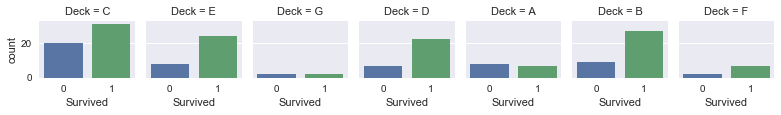

In [11]:
def processCabin(str_t):
	if str_t == None:
		return ''
	m = re.match(r'([a-zA-Z])([0-9]+)$', str_t)
	if m:
		return str(m.group(1))
	return ''
data_train['Cabin'] = data_train['Cabin'].fillna('')
data_train['Deck'] = data_train['Cabin'].map(processCabin)
data_train['HasCabin'] = (data_train.Deck != '')
sns.countplot(hue="Survived", x='HasCabin', data=data_train)
sns.factorplot("Survived", col="Deck", col_wrap=8, data=data_train[data_train.Deck != ''], kind="count", size=1.7, aspect=.9)

### Ticket number
Here we can see that having a cabin improve chance of survival.

In [12]:
def processTicket(ticket):
	if isinstance(ticket, int):
		return ticket
	ticket = ticket.replace(".", "").replace("/", "")
	m = re.match(r'([0-9]+)$', ticket)
	if m:
		return str(int(m.group(1))//1000)
	m2 = re.match(r'([a-zA-Z]+) *([0-9]+)$', ticket)
	if m2:
		result =  m2.group(1)+' '+str(int(m2.group(2))//1000)
		return result.lower()
	return ''
data_train['GTicket'] = data_train['Ticket'].map(processTicket)
d2 = surviveByGroup(data_train, 'GTicket')
d2[d2[('Survived','count')] > 10]

Survived      
               mean count
GTicket                  
11         0.812500    16
17         0.769231    13
13         0.727273    11
19         0.687500    16
pc 17      0.650000    60
330        0.636364    11
248        0.583333    12
29         0.545455    11
250        0.500000    14
113        0.468085    47
36         0.461538    13
scparis 2  0.454545    11
2          0.428571    63
370        0.333333    12
3101       0.250000    16
347        0.234043    47
           0.222222    54
350        0.222222    18
28         0.166667    12
ca 2       0.166667    18
345        0.157895    19
315        0.142857    14
364        0.142857    14
349        0.056604    53

We can see that some group of people having ticket number which are close may have better chances to survive.

# Putting everything together

Now we have review each potential features, we whant to see how each feature are linerly correlated to each other. Of course, we already know that things are more complicated for the age and the family size where we have more complex distribution for the survival, so looking at a linear correlation is useless in our case.

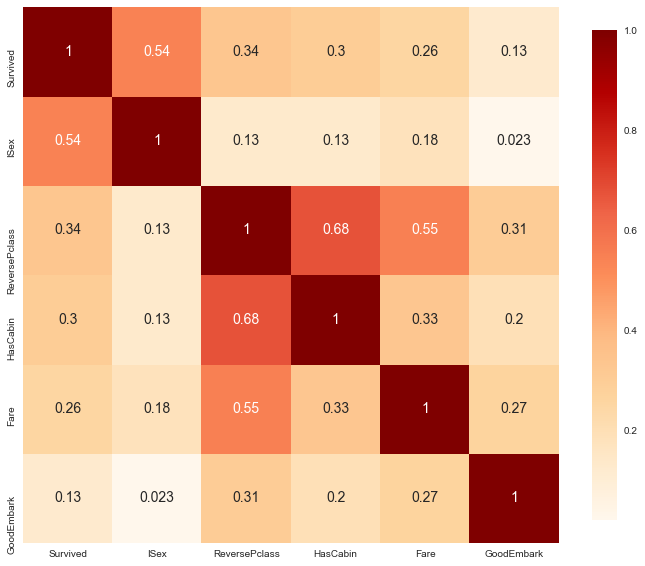

In [13]:
# we reverse the class just to have a positive correlation to obtain : higher number => higher survival
data_train['ISex'] = data_train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
data_train['ReversePclass'] = data_train['Pclass'].map( {1:2,2:1,3:0} ).astype(int)
data_train['GoodEmbark'] = data_train['Embarked'].map( {'C':2,'S':1,'Q':0,None:1} ).astype(int)
# compute the correlation
corr = data_train[['Survived','ISex', 'ReversePclass', "HasCabin", 'Fare', 'GoodEmbark']].corr()
fig , ax = plt.subplots( figsize =( 12 , 10 ) )
_ = sns.heatmap( corr,  cmap = 'OrRd',
    square=True,  cbar_kws={ 'shrink' : .9 }, 
    ax=ax, annot = True,  annot_kws = { 'fontsize' : 14 }
)
plt.show()

We can see that the class, the fare, and having an assigned cabin are linked together : it depends of the overall wealth of the passenger. Also, we know that the title is correlated to the sex of the person.

## About missing values

Now that we review the input data, normally we should have a better understanding on the problem, and also, we could improve the way we filled missing data. Using the median value is a first approximation, so we'll keep the data as it is. But if we wanted to improve our future predictions, it may be better to use another methods to deduce missing value.

## Pretreatment before learning a model

With our data, we need to make categories with the columns Age, Fare, Family Size and the Title

In [14]:
data_train['HasCabin'] = data_train['HasCabin'].map( {None:0, False:0, True:1} ).astype(int)
title_mapping = {'':0, 'None':0, 'Mrs':1, 'Miss':2, 'Mr':3,  'Dr':4, 'Master':5, 'RareA':6, 'RareZ':7, 'RareFem':8, }
data_train['CTitle'] = data_train['Title'].map(title_mapping).astype(int)

data_clean = data_train[['ISex', 'ReversePclass', "HasCabin", 'Fare', 'GoodEmbark', 'FamilySize', 'CTitle', 'Age']]

data_clean.head(5)


,ISex,ReversePclass,HasCabin,Fare,GoodEmbark,FamilySize,CTitle,Age
0,0,0,0,7.2500,1,2.0,3,22.0
1,1,2,1,71.2833,2,2.0,1,38.0
2,1,0,0,7.9250,1,1.0,2,26.0
3,1,2,1,53.1000,1,2.0,1,35.0
4,0,0,0,8.0500,1,1.0,3,35.0


# Model
Now that we selected our features, we can create a model which will be able to predict the survival of any individual based on the trianing dataset. A simple model consists in using a Random Forest Classifier which has several advantages : it doesn't require to have normalized and very well preprocessed data, it can handle numeric data and categorical data, and also, we'll be able to see which feature is the most important and then visualize the decision trees to understand the model a bit.

In [15]:
X_train = data_clean
Y_train = data_train["Survived"]
solver = RandomForestClassifier(criterion='gini', min_samples_split=20, min_samples_leaf=10, max_depth=4, 
                                n_estimators=1000,n_jobs=-1,max_features='auto')
solver.fit(X_train, Y_train);

In [16]:
pd.concat((pd.DataFrame(X_train.iloc[:, :].columns, columns = ['variable']), 
            pd.DataFrame(solver.feature_importances_, columns = ['importance'])), 
            axis = 1).sort_values(by='importance', ascending = False)[:]

,variable,importance
0,ISex,0.311278
6,CTitle,0.288603
1,ReversePclass,0.110081
3,Fare,0.105530
2,HasCabin,0.061512
5,FamilySize,0.058032
7,Age,0.048972
4,GoodEmbark,0.015991


In [17]:
accuracy = round(solver.score(X_train, Y_train) * 100, 2)
print(str(accuracy)+" %")

82.04 %


Now we want to see what one of the decision tree can look like. It's a way to check our model and understand it. A very deep tree can show an overfitted model and a lack of generalisation for instance.

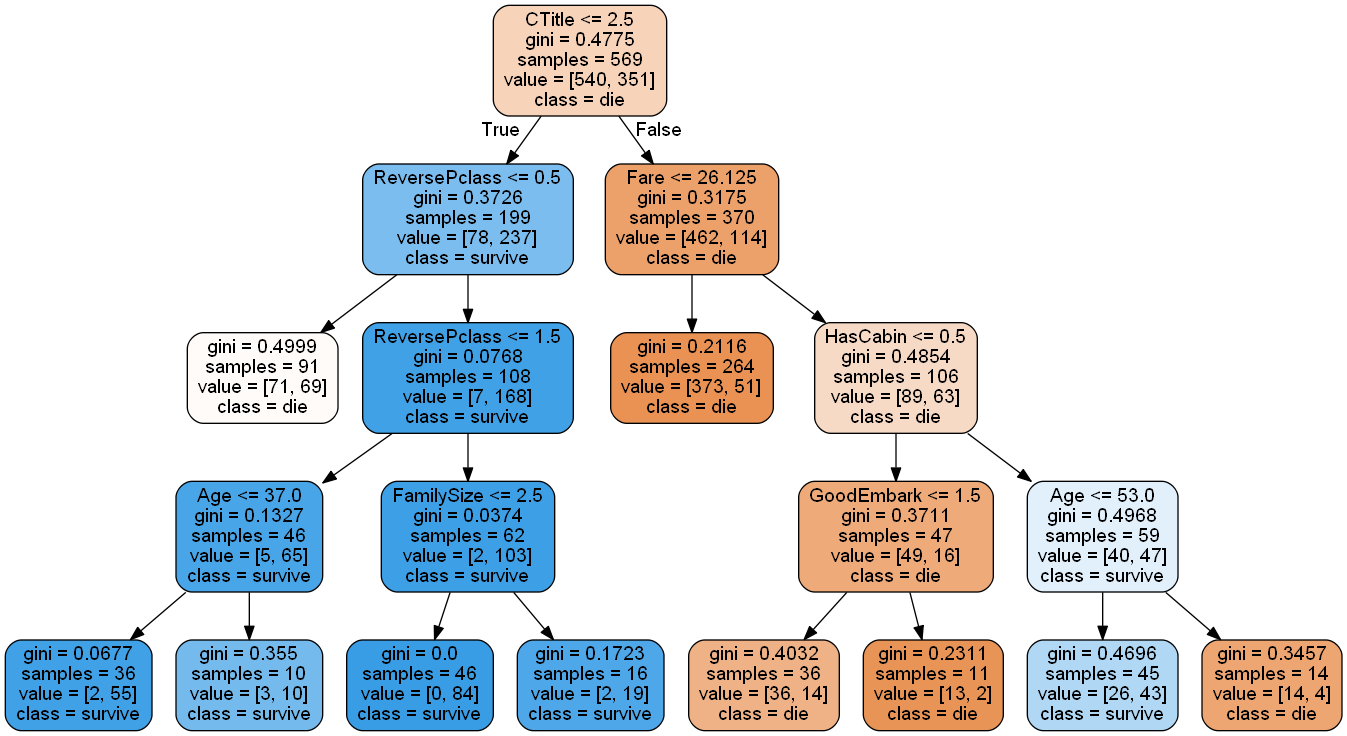

In [18]:
with open('tree0.dot', 'w') as my_file:
	example_tree = solver.estimators_[0]
	my_file = tree.export_graphviz(example_tree, out_file = my_file, feature_names=list(X_train),
                                   filled=True, rounded = True, class_names=['die','survive']  )
check_call(['dot','-Tpng','tree0.dot','-o','tree0.png'])
PImage("tree0.png")

Of course, this model is still simple and general because we limited the depth of the tree to 4 level to have something readable and that won't overfit de training dataset.

To go a bit further, we can try other models and compare them with each other to get better results.